In [61]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm

tw_df = pd.read_csv("data/Twitter_migrated_network.csv")
mast_df = pd.read_csv("data/Mastodon_migrated_network.csv")
user_time_df = pd.read_csv("data/user_timestamps.csv")

In [62]:
print("Twitter links:", tw_df.shape[0])
print("Twitter users:", len(tw_df.source.unique()))
print(tw_df.head())

print("\nMastodon links", mast_df.shape[0])
print("Mastodon users:", len(mast_df.source.unique()))
print(mast_df.head())

Twitter links: 4138546
Twitter users: 72800
   source  target
0   66762   11624
1   66762   30936
2   66762   59955
3   66762   58710
4   66762    1724

Mastodon links 2575656
Mastodon users: 69947
   source  target
0   74721   44677
1   41013   54233
2   41013     463
3   41013   14877
4   41013   50355


In [63]:
user_time_df = user_time_df.sort_values("ts_mastodon")
user_time_df['ts_mastodon'] = pd.to_datetime(user_time_df['ts_mastodon'])
user_time_df['ts_mastodon'] = user_time_df['ts_mastodon'].dt.date

Early-migrants are users registered to Mastodon in 2022 but before October 26th (Elon Musk's takeover).

In [64]:
# slice from January 1st, 2022 to January 19th, 2023  
sliced_time_df = user_time_df[(user_time_df['ts_mastodon'] >= date(2022, 1, 1)) & (user_time_df['ts_mastodon'] <= date(2023, 1, 19))]
sliced_time_df['ts_mastodon'] = pd.to_datetime(sliced_time_df['ts_mastodon'])
start_date = pd.to_datetime('2022-10-26')
sliced_time_df.loc[:,'day'] = (sliced_time_df['ts_mastodon'] - start_date).dt.days
sliced_time_df['day'] = sliced_time_df['day'].apply(lambda x: max(x, 0)) # Early-migrants also marked as initial infected

/tmp/ipykernel_19095/3854817910.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sliced_time_df['ts_mastodon'] = pd.to_datetime(sliced_time_df['ts_mastodon'])
/tmp/ipykernel_19095/3854817910.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sliced_time_df.loc[:,'day'] = (sliced_time_df['ts_mastodon'] - start_date).dt.days
/tmp/ipykernel_19095/3854817910.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [65]:
sliced_time_df.to_csv("data/sliced_user_timestamps.csv")

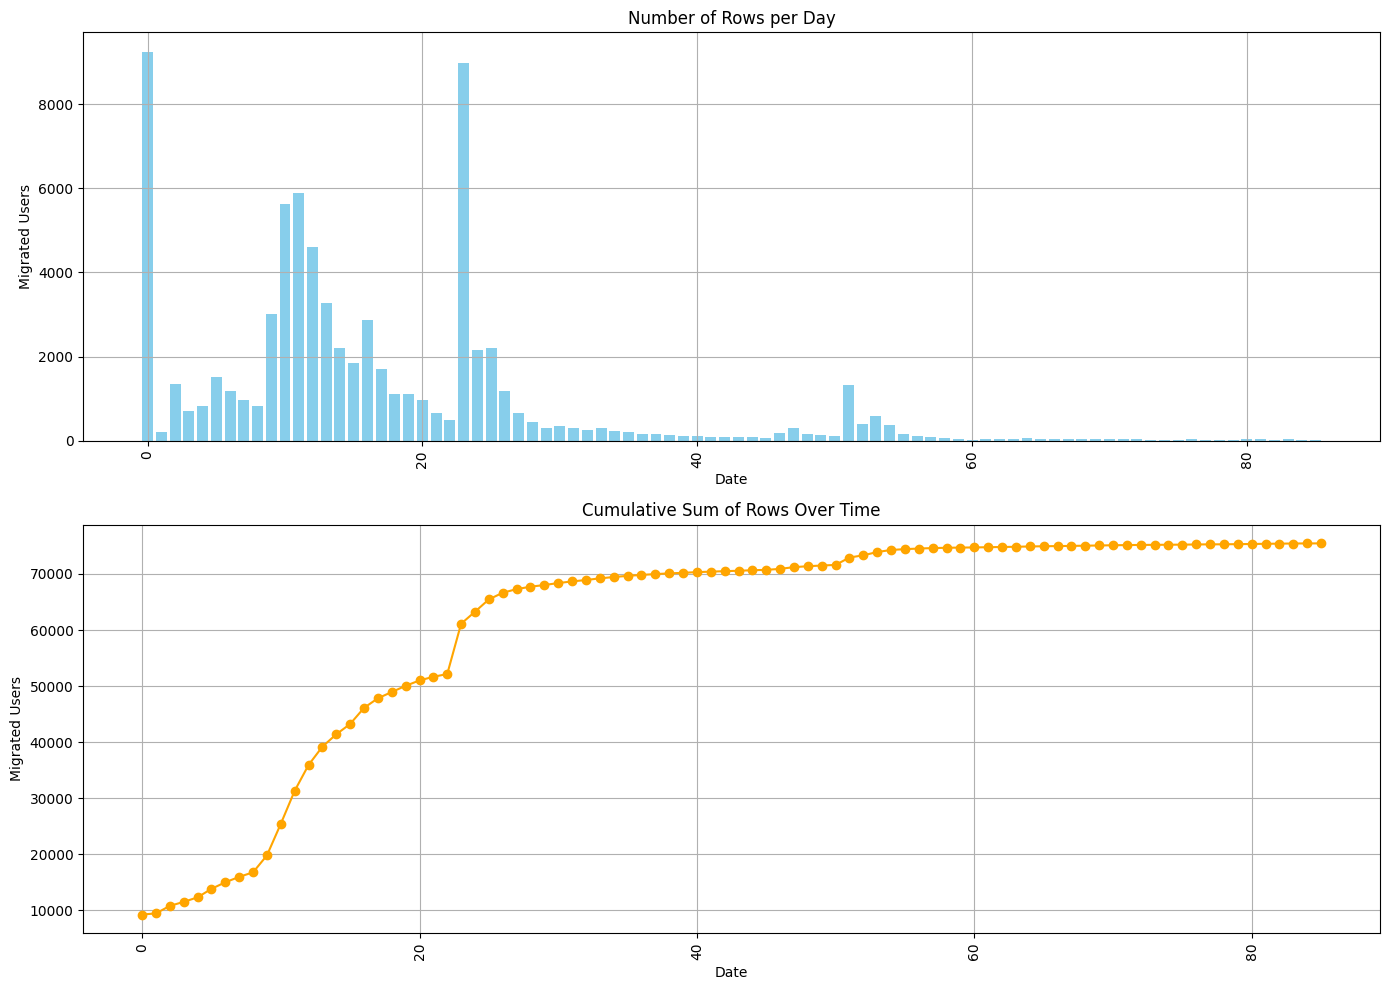

In [59]:
date_counts = sliced_time_df['day'].value_counts().sort_index()

# Calculate the cumulative sum of the daily counts
cumulative_sum = date_counts.cumsum()

# Create a figure with 2 subplots (1 row, 2 columns)
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Plot the number of rows per day (Histogram)
ax[0].bar(date_counts.index, date_counts.values, width=0.8, color='skyblue')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Migrated Users')
ax[0].set_title('Number of Rows per Day')
ax[0].tick_params(axis='x', rotation=90)  # Rotate date labels for better readability
ax[0].grid(True)

# Plot the cumulative sum
ax[1].plot(cumulative_sum.index, cumulative_sum.values, marker='o', linestyle='-', color='orange')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Migrated Users')
ax[1].set_title('Cumulative Sum of Rows Over Time')
ax[1].tick_params(axis='x', rotation=90)  # Rotate date labels for better readability
ax[1].grid(True)

# Adjust layout to prevent overlap and improve aesthetics
plt.tight_layout()
plt.show()

### **Preprocessing 1.1: Network pruning** 
Prune the Migration Network using the Disparity Filter method with edge weighting based on the Jaccard coefficient.

In [56]:
def jaccard_coefficient(df, i, j):
  """
  Calculates the Jaccard coefficient between the out-neighbors of i and in-neighbors of j.
  """
  out_neighbors_i = set(df[df['source'] == i]['target'])
  in_neighbors_j = set(df[df['target'] == j]['source'])
  intersection = len(out_neighbors_i.intersection(in_neighbors_j))
  union = len(out_neighbors_i.union(in_neighbors_j))
  return intersection / float(union) if union > 0 else 0  # Avoid division by zero

# Create an empty directed graph migration_network
migration_network = nx.DiGraph()

# Add edges to the graph with Jaccard weight
for line in tqdm(tw_df.iterrows(), total=tw_df.shape[0]):
    source = int(line[1].iloc[0])  
    target = int(line[1].iloc[1])  
    weight = jaccard_coefficient(tw_df, source, target)
    migration_network.add_edge(source, target, weight=weight)
    

100%|██████████████████████████████████████████████████████████████████████| 4138546/4138546 [8:28:40<00:00, 135.60it/s]


In [13]:
migration_network = nx.read_gml("migration_network.gml")

In [20]:
from src.backbone_network import get_graph_backbone
migration_backbone = get_graph_backbone(migration_network)


In [21]:
nx.write_gml(migration_backbone, "migration_backbone.gml")

In [25]:
print("Migration Full Network")
print("Number of nodes:", migration_network.number_of_nodes())
print("Number of edges:", migration_network.number_of_edges())
print("Density of the graph:", nx.density(migration_network))
print("\nMigration Backbone Network")
print("Number of nodes:", migration_backbone.number_of_nodes())
print("Number of edges:", migration_backbone.number_of_edges())
print("Density of the graph:", nx.density(migration_backbone))

Migration Full Network
Number of nodes: 74132
Number of edges: 4138546
Density of the graph: 0.0007530819024329061

Migration Backbone Network
Number of nodes: 74132
Number of edges: 3579248
Density of the graph: 0.0006513077039905258


### **Preprocessing 1.2: Community detection**

Community detection on the Migration Network using the Louvain algorithm.

In [7]:
migration_backbone = nx.read_gml("migration_backbone.gml")

In [9]:
import community as community_louvain

# Partition dictionary maps each node in the UNDIRECTED network to its assigned community ID
partition = community_louvain.best_partition(migration_backbone.to_undirected()) 

In [16]:
# Example: Print community ID for node 123
node_id = "123"
community_of_node = partition[node_id]
print(f"Node {node_id} belongs to community {community_of_node}")

Node 123 belongs to community 5


In [30]:
print("Number of communities:", len(set(partition.values())))

Number of communities: 4647


We take the most populated community and we will experiment with it

In [33]:
from src.utils import filter_most_frequent_values
top_comm = filter_most_frequent_values(partition)
print("Number of elements in the top community:", len(top_comm))

Number of elements in the top community: 12129


### **Preprocessing 1.3: Top Community Network**

In [38]:
nodes_to_include = top_comm.keys()
subgraph = migration_backbone.subgraph(nodes_to_include).copy()
nx.write_gml(subgraph, "migration_top_comm.gml")